In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.cluster import KMeans as kmeans
from sklearn.cluster import Birch
# from h2o4gpu.solvers.kmeans import KMeans as kmeans
# from h2o4gpu.cluster import Birch
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats


In [3]:
def read_data(path:str):
    df = pd.read_csv(path, usecols = [0, 1, 2]) 
    df.columns = ['x','y','z']
    return df

In [4]:
def apply_kmeans(df:pd.DataFrame,n_cl,cent):
    
    """
    This function applies sklearns kmeans clustering algorithm. 
    It takes as input a dataframe with 2 coordinates x and y  along with two parameters for initialization
    namely number of clusters and their centers.
    It returns labels, cluster centers, predicted label and distance from cluster centers respectively 
    """
    
    kmn = kmeans(n_clusters=n_cl, init = cent, n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=36, copy_x=True, n_jobs=None, algorithm='auto').fit(df[['x','y']])
    label = kmn.labels_
    out = kmn.predict(df[['x','y']])
    cent = kmn.cluster_centers_
    dist = kmn.transform(df[['x','y']])
    agmn = np.argmin(dist, axis = 1)
    c_dist = np.empty_like(agmn, dtype = np.float32)
    for dst in range(len(agmn)):
        c_dist[dst] = dist[dst, agmn[dst]]    
    return (label,cent,out,c_dist)


In [5]:
def apply_birch(df:pd.DataFrame,th):
    
    """
    This function applies sklearns birch clustering algorithm. 
    It takes as input a dataframe with 2 coordinates x and y  along with a parameters called thresholding factor 
    for initialization of birch
    It returns labels, cluster centers, predicted label and distance from cluster centers respectively 
    """
    
    data = df[['x','y']]
    brc = Birch(branching_factor=50, n_clusters=None, threshold=th, compute_labels=True)
    brc.fit(data)
    label = brc.predict(data)
    out = brc.labels_
    
    cent = brc.subcluster_centers_
    dist = brc.transform(data)
    agmn = np.argmin(dist, axis = 1)
    c_dist = np.empty_like(agmn, dtype = np.float32)
    for dst in range(len(agmn)):
        c_dist[dst] = dist[dst, agmn[dst]]    
    return (label,cent,out,c_dist)


In [6]:
def plot_cluster(X,Y,Z,label,cent):
    
    """
    This function plots results of kmeans prediction along with cluster centers
    """
    
    for i in list(np.unique(label)):
        x = X[label.ravel()==i]
        y = Y[label.ravel()==i]
        z = Z[label.ravel()==i]
        plt.scatter(x,y)
    plt.scatter(cent[:,0],cent[:,1],s = 80,c = 'y', marker = 's')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.show()

In [7]:
def adapt_buffer(x1,y1,z1,r1,lbl,it_max):
    
    """
    This function applies a buffer to the cluster adaptively. It operates on 2 dimentional[r,z] data 
    instead of 3 dimentional[x,y,z].It runs until convergence. In every iteration it first computes 
    the center position(ric1,z1c1) and then recomputes radial distance from center r. it then removes 
    the points that lie beyond average of (min of r (supposed trunk boundary) and max of r (cluster boundary)).
    It then recomputes the center boundary and uses the change in center position (r) for loop termination criteria.
    
    It returns the lists of reduced points(x,y,z,r)
    """
    
    esp = 100
    k = 0
    l1 = len(r1)
    while esp > 0.05 and k<it_max and len(x1)>100:
        r1c1 = np.average(r1)
        z1c1 = np.average(z1)
        r1 = (r1-r1c1)
        l1 = len(r1)
        
        z1 = (z1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
        x1 = (x1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
        y1 = (y1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
        r1 = (r1[(r1<(min(np.absolute(r1))+max(np.absolute(r1)))/2)]).reshape(-1,1)
        
        l2 = len(r1)
        r1c2 = np.average(r1)
        esp = (np.absolute(r1c1 - r1c2))/(np.absolute(r1c1)+1)
        #esp = 100*(l1-l2)/(l1)
        
        k += 1
    
    f_l1 = (np.ones(len(x1))*lbl).reshape(-1,1)
    return (x1,y1,z1,r1)
        

In [8]:
def zr_adjust(x1,y1,z1,r1,it_max):
    
    """
    This function is inspired from Mohr circle representation. It computes the center(r2m) and radius(rd) 
    of mohr circle that is formed by boundaries of all points lying in a cluster. It iteratively searches 
    for the tree trunk in the mohr circle using binary search algorithm.In every iteration it compares the density 
    (number of points factored by height range for that region) of points
    lying in each of the two regions (inner circle and outer ring) of mohr circle and selects the region with higher density
    (more likely to contain the trunk).It repeats the search until convergence. 
    The percentage change in the density of two regions is used as convergence criteria.
    Finally it returns the subset of points lying within the region most likely to contain the trunk.
    """
    
    esp2 = 100
    kl = 0
    r2 = r1
    while esp2 > 0.05 and kl <it_max and len(r2)>50:
        r2mn = np.min(r2)
        r2mx = np.max(r2)
        r2m = (r2mn + r2mx)/2
        rd = (r2mx -r2mn)/2 
        
        r2 = r2 - r2m
        
        z11 = z1[(r2 <= rd/2) & (r2>= -rd/2)]
        z12 = z1[(r2 > rd/2) & (r2<= -rd/2)]
        fc1 = len(z11)
        fc2 = len(z12)
        fc = np.absolute(fc1-fc2)
        if fc1>fc2:
            esp2 = fc/fc1
            kl += 1
    
            ir1 = -rd/2
            ir2 = rd/2

            
        else:
            z21 = z1[(r2 >= rd/2) & (r2<= rd)]
            z22 = z1[(r2 >= -rd) & (r2<= -rd/2)]
            fc1 = len(z21)*np.ptp(z21)
            fc2 = len(z22)*np.ptp(z22)
            fc = np.absolute(fc1-fc2)
            
            if fc1>fc2:
                esp2 = fc/fc1
                kl += 1

                ir1 = rd/2
                ir2 = rd
                
            else:
                esp2 = fc/fc2
                kl += 1

                ir1 = -rd
                ir2 = -rd/2
                                 
        
        r1 = r1[(r2>=ir1) & (r2<=ir2)]
        r1 = r1.reshape(-1,1)
        x1 = x1[(r2>=ir1) & (r2<=ir2)]
        x1 = x1.reshape(-1,1)
        y1 = y1[(r2>=ir1) & (r2<=ir2)]
        y1 = y1.reshape(-1,1)
        z1 = z1[(r2>=ir1) & (r2<=ir2)]
        z1 = z1.reshape(-1,1)
        r2 = r2[(r2>=ir1) & (r2<=ir2)]
        r2 = r2.reshape(-1,1)

    return (x1,y1,z1,r1)


In [9]:
def x_finder(x1,y1,z1,r1,step,itmax):
    
    """
    This function is similar to zr_adjust function. But it searches for the trunk in x dimension instead of r. 
    It is applied after trunk is already located in r dimention using zr_adjust function.  
    """
    
    esp2 = 100
    kl = 0
    x_2 = x1
    while esp2 > 0.05 and kl<itmax and np.ptp(x_2) > 0.5 and len(x_2)> step:
        
        x2mn = np.min(x_2)
        x2mx = np.max(x_2)
        x2m = (x2mn + x2mx)/2
        
        z11 = z1[(x1 >= x2mn) & (x1 <= x2m)]
        z12 = z1[(x1 > x2m) & (x1 <= x2mx)]
        fc1 = len(z11)*np.ptp(z11)
        fc2 = len(z12)*np.ptp(z12)
        fc = np.absolute(fc1-fc2)
        if fc1>fc2:
            ix1 = x2mn
            ix2 = x2m
            
            x_2 = x_2[(x_2>=ix1) & (x_2<=ix2)]
            x_2 = x_2.reshape(-1,1)
        
            esp2 = fc/fc1
            kl += 1
    
        else:
            ix1 = x2m
            ix2 = x2mx
            x_2 = x_2[(x_2>=ix1) & (x_2<=ix2)]
            x_2 = x_2.reshape(-1,1)
            esp2 = fc/fc2
            kl += 1
    
    ix1 = np.min(x_2)
    ix2 = np.max(x_2)
    r1 = r1[(x1>=ix1) & (x1<=ix2)]
    y1 = y1[(x1>=ix1) & (x1<=ix2)]
    z1 = z1[(x1>=ix1) & (x1<=ix2)]
    x1 = x1[(x1>=ix1) & (x1<=ix2)]
    

    x1 = x1.reshape(-1,1)
    y1 = y1.reshape(-1,1)
    z1 = z1.reshape(-1,1)
    r1 = r1.reshape(-1,1)
    return (x1,y1,z1,r1)


In [10]:
def plot_3d(X_sub, Y_sub, Z_sub, l_sub):
    
    """
    This function plots each cluster in a 3d projection
    """
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Elevation')
    for lbl in list(np.unique(l_sub)):
        ax.scatter(X_sub[l_sub == lbl], Y_sub[l_sub == lbl], Z_sub[l_sub == lbl])

    plt.show() 

In [11]:
def plot_2d(X_sub, Y_sub, Z_sub, l_sub):
    
    """
    This function plots each cluster in a 2d projection
    """
    
    for lbl in list(np.unique(l_sub)):
        plt.scatter(X_sub[l_sub == lbl], Y_sub[l_sub == lbl], Z_sub[l_sub == lbl])

In [12]:
def sub_set(X,Y,Z,label,hm,hc):
    
    """
    This function subset the data points in each cluster based on height. it takes as argument
    the three coordinates of datapoints, their cluster labels, lower height cutoff hm 
    and fraction of height factor hc for upper limit.
    """
    

    X_sub = []
    Y_sub = []
    Z_sub = []
    l_sub = []

    for lbl in list(np.unique(label)):
        x1 = (X[label == lbl]).reshape(-1,1)
        y1 = (Y[label == lbl]).reshape(-1,1) 
        z1 = (Z[label == lbl]).reshape(-1,1)
        
        x1 = (x1[(z1>(min(z1)+hm)) & (z1<min(z1)+hm+min(tree_H[lbl]*hc, 20))]).reshape(-1,1)
        y1 = (y1[(z1>(min(z1)+hm)) & (z1<min(z1)+hm+min(tree_H[lbl]*hc, 20))]).reshape(-1,1)
        z1 = (z1[(z1>(min(z1)+hm)) & (z1<min(z1)+hm+min(tree_H[lbl]*hc, 20))]).reshape(-1,1)
        
        l1 = (np.ones(len(x1))*lbl).reshape(-1,1)
        
        X_sub.extend(x1)
        Y_sub.extend(y1)
        Z_sub.extend(z1)
        l_sub.extend(l1)
    
    X_sub = np.array(X_sub).reshape(-1,1)
    Y_sub = np.array(Y_sub).reshape(-1,1)
    Z_sub = np.array(Z_sub).reshape(-1,1)
    l_sub = np.array(l_sub).reshape(-1,1)
    
    return X_sub, Y_sub, Z_sub, l_sub


In [13]:
def apply_buffer_zrAdjust_xFinder(X, Y, Z, c_dist, label,it_max):
    X_sub = []
    Y_sub = []
    Z_sub = []
    R_sub = []
    l_sub = []


    for lbl in list(np.unique(label)):
        x1 = list(X[label == lbl])
        y1 = list(Y[label == lbl])   
        z1 = list(Z[label == lbl])
        r1 = list(c_dist[label == lbl])
        
        
        
        z1 = (np.array(z1)).reshape(-1,1)
        r1 = (np.array(r1)).reshape(-1,1)
        x1 = (np.array(x1)).reshape(-1,1)
        y1 = (np.array(y1)).reshape(-1,1)
        
        x1,y1,z1,r1 = adapt_buffer(x1,y1,z1,r1,lbl,it_max)
        if len(r1)>10:
            x1,y1,z1,r1 = zr_adjust(x1,y1,z1,r1,it_max)
        else:
            continue
        if len(r1)>10:
            x1,y1,z1,r1 = x_finder(x1,y1,z1,r1,25,it_max) 
        else:
            continue
        if len(r1)>10:
            y1,x1,z1,r1 = x_finder(y1,x1,z1,r1,10,it_max)
        else:
            continue
        
        l1 = (np.ones(len(x1))*lbl).reshape(-1,1)
        
        X_sub.extend(x1)
        Y_sub.extend(y1)
        Z_sub.extend(z1)
        R_sub.extend(r1)        
        l_sub.extend(l1)
        

    X_sub = np.array(X_sub).reshape(-1,1)
    Y_sub = np.array(Y_sub).reshape(-1,1)
    Z_sub = np.array(Z_sub).reshape(-1,1)
    l_sub = np.array(l_sub).reshape(-1,1)
    R_sub = np.array(R_sub).reshape(-1,1)


    return X_sub, Y_sub, Z_sub, R_sub, l_sub


In [14]:
def width_finder(px, py, pz,pl):
    
    """
    This function computes the depth at breast height (dbh) parameter 
    for all clusters/trees using the median value of width of all clusters/trees
    """
    
    w = []
    for lbl in list(np.unique(pl)):
        x1,y1,z1 = px[pl == lbl], py[pl == lbl], pz[pl == lbl]
        
        if len(x1)<=1:
            w1 = 0
        else:
            w1 = max(np.ptp(x1),np.ptp(y1))
        w.append(w1)
        
    w = (np.array(w)).reshape(-1,1)
    dbh = np.median(w)
    
    return w,dbh

In [15]:
def get_unique_points_pandas(df:pd.DataFrame,sub = None):

    df = df.drop_duplicates(subset = sub)
    return df

In [16]:
def get_unique_points(X_f,Y_f,Z_f,R_f,l_f):
    X_f4 = []
    Y_f4 = []
    Z_f4 = []
    R_f4 = []
    l_f4 = []
    

    for lbl in list(np.unique(l_f)):

        x1,y1,z1,r1,l1 = X_f[l_f == lbl], Y_f[l_f == lbl], Z_f[l_f == lbl], R_f[l_f == lbl], l_f[l_f == lbl]
        
        df2 = pd.DataFrame({'x':x1,'y':y1,'z':z1,'r':r1,'l':l1})
        df2 = get_unique_points_pandas(df2)
        
        X_f4.extend(df2['x'])
        Y_f4.extend(df2['y'])
        Z_f4.extend(df2['z'])
        R_f4.extend(df2['r'])    
        l_f4.extend(df2['l'])
        
    X_f4 = np.array(X_f4).reshape(-1,1)
    Y_f4 = np.array(Y_f4).reshape(-1,1)
    Z_f4 = np.array(Z_f4).reshape(-1,1)
    R_f4 = np.array(R_f4).reshape(-1,1)
    l_f4 = np.array(l_f4).reshape(-1,1)
    
    return X_f4,Y_f4,Z_f4,R_f4,l_f4

In [17]:
def extract_all_cluster_centers(X_f,Y_f,Z_f,R_f,l_f):    
    w1,dbh = width_finder(X_f,Y_f,Z_f,l_f)

    l_list = list(np.unique(l_f))
    centr = np.empty((len(l_list),5))
    np.set_printoptions(precision=2)
    for k,lbl in enumerate(l_list):

        x1,y1,z1,r1,l1 = X_f[l_f == lbl], Y_f[l_f == lbl], Z_f[l_f == lbl], R_f[l_f == lbl], l_f[l_f == lbl]
        if len(z1) >1:
            centr[k,0] = np.round(np.average(x1),2)
            centr[k,1] = np.round(np.average(y1),2)
            centr[k,2] = np.round(np.max(z1) - np.min(z1),2)
            centr[k,3] = np.round(w1[k],2)
            centr[k,4] = np.round(lbl)
            print("Cluster {}: center: ({},{}), height: {}, width:{}".format(int(lbl),centr[k,0],centr[k,1],centr[k,2],centr[k,3]))
    return centr   

In [18]:
def filter_cluster_points_by_radius_height(X_f,Y_f,Z_f,R_f,l_f):
    
    X_f2 = []
    Y_f2 = []
    Z_f2 = []
    R_f2 = []
    l_f2 = []


    for lbl in list(np.unique(l_f)):

        x1,y1,z1,r1,l1 = X_f[l_f == lbl], Y_f[l_f == lbl], Z_f[l_f == lbl], R_f[l_f == lbl], l_f[l_f == lbl]
        z2 = z1 - np.min(z1)
        dataset = pd.DataFrame({'x':x1,'y':y1,'z2':z2,'r':r1,'l':l1,'z':z1})
        dataset = dataset[(stats.zscore(dataset.iloc[:,3:4]) < 1.96).all(axis=1)]
        dataset = dataset[(np.abs(stats.zscore(dataset.iloc[:,2:3])) < 1.96).all(axis=1)]


        print("Number of points in cluster :{} dropped from {} to {}".format(int(lbl),len(x1),len(dataset['x'])))

        X_f2.extend(dataset['x'])
        Y_f2.extend(dataset['y'])
        Z_f2.extend(dataset['z'])
        R_f2.extend(dataset['r'])   
        l_f2.extend(dataset['l'])

    X_f2 = np.array(X_f2).reshape(-1,1)
    Y_f2 = np.array(Y_f2).reshape(-1,1)
    Z_f2 = np.array(Z_f2).reshape(-1,1)
    R_f2 = np.array(R_f2).reshape(-1,1)
    l_f2 = np.array(l_f2).reshape(-1,1)
    
    return X_f2,Y_f2,Z_f2,R_f2,l_f2

In [19]:
def drop_cluster_with_lower_count(X_f2,Y_f2,Z_f2,R_f2,l_f2):
    X_f3 = []
    Y_f3 = []
    Z_f3 = []
    R_f3 = []
    l_f3 = []

    a1,a2 = np.unique(l_f2,return_counts = True)
    df3 = pd.DataFrame({'l':a1,'count':a2})

    df3 = df3[np.absolute(stats.zscore(df3.iloc[:,1:2]) < 1.96).all(axis=1)]
    print(df3.shape)

    print("Number of clusters dropped from {} to {}".format(len(a1),len(df3)))
    
    for lbl in list(set(df3['l'])):
        x2,y2,z2,r2,l2 = X_f2[l_f2 == lbl], Y_f2[l_f2 == lbl], Z_f2[l_f2 == lbl], R_f2[l_f2 == lbl], l_f2[l_f2 == lbl]


        X_f3.extend(x2)
        Y_f3.extend(y2)
        Z_f3.extend(z2)
        R_f3.extend(r2)  
        l_f3.extend(l2)
    X_f3 = np.array(X_f3).reshape(-1,1)
    Y_f3 = np.array(Y_f3).reshape(-1,1)
    Z_f3 = np.array(Z_f3).reshape(-1,1)
    R_f3 = np.array(R_f3).reshape(-1,1)
    l_f3 = np.array(l_f3).reshape(-1,1)
    
    return X_f3,Y_f3,Z_f3,R_f3,l_f3

In [20]:
path = './Full_Point.csv'
dataset = read_data(path)

X = dataset['x']
Y = dataset['y']
Z = dataset['z']
    
xmax, xmin = np.max(X), np.min(X)
ymax, ymin = np.max(Y), np.min(Y)
xm = (xmax + xmin)/2
ym = (ymax + ymin)/2
X1 = X[(X<=xm) & (X>=xmin) & (Y<=ym) & (Y>=ymin)]
Y1 = Y[(X<=xm) & (X>=xmin) & (Y<=ym) & (Y>=ymin)]
Z1 = Z[(X<=xm) & (X>=xmin) & (Y<=ym) & (Y>=ymin)]

X2 = X[(X<=xmax) & (X>=xm) & (Y<=ym) & (Y>=ymin)]
Y2 = Y[(X<=xmax) & (X>=xm) & (Y<=ym) & (Y>=ymin)]
Z2 = Z[(X<=xmax) & (X>=xm) & (Y<=ym) & (Y>=ymin)]

X3 = X[(X<=xm) & (X>=xmin) & (Y<=ymax) & (Y>=ym)]
Y3 = Y[(X<=xm) & (X>=xmin) & (Y<=ymax) & (Y>=ym)]
Z3 = Z[(X<=xm) & (X>=xmin) & (Y<=ymax) & (Y>=ym)]

X4 = X[(X<=xmax) & (X>=xm) & (Y<=ymax) & (Y>=ym)]
Y4 = Y[(X<=xmax) & (X>=xm) & (Y<=ymax) & (Y>=ym)]
Z4 = Z[(X<=xmax) & (X>=xm) & (Y<=ymax) & (Y>=ym)]



In [21]:
print((xmax-xmin),(ymax-ymin))

36.25400000000445 21.983000000000175


In [22]:
print(np.max(Z) - np.min(Z))

46.35000000000002


In [23]:
arr = np.empty((len(X),3))
arr[:,0] = np.array(X)
arr[:,1] = np.array(Y)
arr[:,2] = np.array(Z)

In [24]:
dataset = pd.DataFrame({'Column1': X1, 'Column2': Y1,'Column3': Z1})
dataset.to_csv('./grid1_subset_subset_input3.csv', header=None, index=None)

In [25]:

hm = [1.5,3,4.5,6,7.5]
hc = [0.5,0.37,0.25]

itr = [2,4,6]
ht = [1.7,2.5,3.5]

print(hm)
print(hc)
print(itr)
Xf =np.empty((1,1))
Yf =np.empty((1,1))
Zf =np.empty((1,1))
Wf = np.empty((1,len(itr)))
num_f = np.empty((1,len(itr)))
Xcntrd = []
Ycntrd = []
# x = arr[:,0]
# y = arr[:,1]
# z = arr[:,2]
x=arr[:,0]
y=arr[:,1]
z=arr[:,2]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
z = z.reshape(-1,1)


w,h = np.abs(xmax-xmin), np.abs(ymax-ymin)
print(h,w)

hmargin = 0
wmargin = 0
# hstep = h/200
# wstep = w/200

hstep = 10
wstep = 10

ar1= (np.arange(ymin,ymax+1,hstep))
ar1 = ar1[:-1]
#print(ar1)
ar2= np.arange(xmin,xmax+1,wstep)
ar2 = ar2[:-1]
#print(ar2)

ar1 = list(ar1.ravel())
ar2 = list(ar2.ravel())

label = np.empty((len(x),1))
label = label.astype(np.uint8)
k=0
for id in ar1:
    for di in ar2:
        label[(x>=di)&(x<=di+wstep)&(y>=id)&(y <= id + hstep)] = k
        k+=1
print('initial label added based on grid')
del k
num_tree = len(np.unique(label))
# tree_H = np.empty(k, dtype = np.float32)
tree_H = np.empty(num_tree, dtype = np.float32)
print(label.shape,z.shape,num_tree,tree_H.shape)
for lbl in list(np.unique(label)):
    tree_H[lbl] = np.max(z[label == lbl]) - np.min(z[label == lbl])
print('height computed for each sub grid')
print(np.min(tree_H), np.max(tree_H),np.median(tree_H))  

DBH = []   
z = z.reshape(-1,)
label = label.reshape(-1,)
i = 0



subsets_by_height  = [[mh,ch] for mh in hm for ch in hc]

for sub in subsets_by_height:
    
    X_sub, Y_sub, Z_sub, l_sub = sub_set(x,y,z,label,sub[0],sub[1])
    
    for th in ht: 
        
        label2,cent2,out2,c_dist2 = apply_birch(pd.DataFrame({'x':X_sub.ravel(), 'y':Y_sub.ravel()}),th)

        for rti in itr:
            X_sub2, Y_sub2, Z_sub2, R_sub2, l_sub2 = apply_buffer_zrAdjust_xFinder(X_sub, Y_sub, Z_sub, c_dist2, label2,it_max=rti)

            w,dbh = width_finder(X_sub2, Y_sub2, Z_sub2, l_sub2)
            DBH.append(dbh)
            print(i,': ',dbh)

            Xf = np.concatenate((Xf,X_sub))
            Yf = np.concatenate((Yf,Y_sub))
            Zf = np.concatenate((Zf,Z_sub))

            i+=1
    
            
Xf = (Xf).reshape(-1,1)
Yf = (Yf).reshape(-1,1)
Zf = (Zf).reshape(-1,1)

Xf = Xf[1:,:]
Yf = Yf[1:,:]
Zf = Zf[1:,:]
final_dbh = np.median(np.array(DBH))
print("DBH: ",final_dbh)

[1.5, 3, 4.5, 6, 7.5]
[0.5, 0.37, 0.25]
[2, 4, 6]
21.983000000000175 36.25400000000445
initial label added based on grid
(1048575, 1) (1048575, 1) 6 (6,)
height computed for each sub grid
29.14 40.08 35.52
0 :  0.40200000000186265
1 :  0.43399999999928696
2 :  0.46850000000085856
3 :  0.6610000000036962
4 :  0.3349999999991269
5 :  0.7289999999993597
6 :  0.8689999999987776
7 :  0.3899999999994179
8 :  0.555000000000291
9 :  0.385999999998603
10 :  0.466999999996915
11 :  0.48549999999704596
12 :  0.6084999999984575
13 :  0.3364999999976135
14 :  0.7255000000022847
15 :  0.9109999999964202
16 :  0.40600000000267755
17 :  0.5120000000024447
18 :  0.39500000000043656
19 :  0.45199999999749707
20 :  0.49200000000564614
21 :  0.5815000000002328
22 :  0.36599999999998545
23 :  0.5490000000027067
24 :  1.0855000000028667
25 :  0.31049999999959255
26 :  0.5044999999990978
27 :  0.41499999999723514
28 :  0.3600000000005821
29 :  0.4440000000031432
30 :  0.6060000000034051
31 :  0.3379999999961

In [26]:
print(len(Xf),len(Yf),len(Zf))

11474217 11474217 11474217


In [27]:
darr2 = pd.DataFrame({'x':Xf.ravel(),'y':Yf.ravel(),'z':Zf.ravel()})
darr2 = get_unique_points_pandas(darr2)
Xf,Yf,Zf = darr2['x'],darr2['y'],darr2['z']

In [28]:
print(len(Xf),len(Yf),len(Zf))

277963 277963 277963


In [29]:
label_3,cent_3,out_3,c_dist_3 = apply_birch(pd.DataFrame({'x':Xf.ravel(), 'y':Yf.ravel()}),1.7)
print(len(cent_3))



95


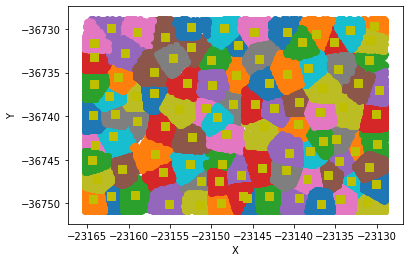

In [30]:
plot_cluster(Xf,Yf,Zf,label_3,cent_3)

In [31]:
dataset = pd.DataFrame({'X': Xf, 'Y': Yf,'Z': Zf, 'Label': label_3})
dataset.to_csv('./grid3_after_birch_output.csv', header=None, index=None)

In [32]:
print(len(np.unique(label_3)))

95


In [33]:
label3,cent3,out3,c_dist3 = apply_kmeans(pd.DataFrame({'x':Xf.ravel(), 'y':Yf.ravel()}),len(np.unique(label_3)),'k-means++')
print(len(cent3))

95


In [34]:
dataset = pd.DataFrame({'X': Xf, 'Y': Yf,'Z': Zf, 'Label': out3})
dataset.to_csv('./grid3_after_kmeans_output2.csv', header=None, index=None)

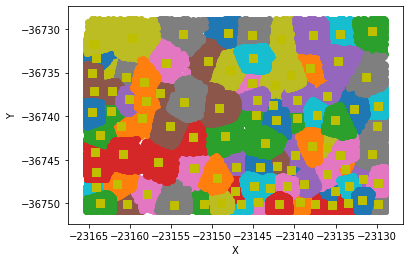

In [35]:
plot_cluster(Xf,Yf,Zf,label3,cent3)

In [36]:
w = 1.5*final_dbh*np.ones((len(cent3),1))
print(w.shape)
X_f = []
Y_f = []
Z_f = []
R_f = []
l_f = []

for lbl in list(set(out3.ravel())):

    x1,y1,z1,r1,l1 = Xf[out3 == lbl], Yf[out3 == lbl], Zf[out3 == lbl], c_dist3[out3 == lbl], out3[out3 == lbl]
    
    x1 = x1[r1<=w[lbl]]
    y1 = y1[r1<=w[lbl]]
    z1 = z1[r1<=w[lbl]]
    l1 = l1[r1<=w[lbl]]
    r1 = r1[r1<=w[lbl]]
    
    X_f.extend(x1)
    Y_f.extend(y1)
    Z_f.extend(z1)
    R_f.extend(r1)
    l_f.extend(l1)
    
X_f = np.array(X_f).reshape(-1,1)
Y_f = np.array(Y_f).reshape(-1,1)
Z_f = np.array(Z_f).reshape(-1,1)
R_f = np.array(R_f).reshape(-1,1)
l_f = np.array(l_f).reshape(-1,1)

X_f,Y_f,Z_f,R_f,l_f = apply_buffer_zrAdjust_xFinder(X_f,Y_f,Z_f,R_f,l_f,it_max=1)

(95, 1)


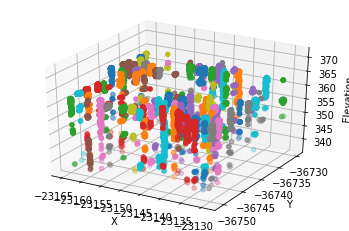

In [37]:
plot_3d(X_f,Y_f,Z_f,l_f)

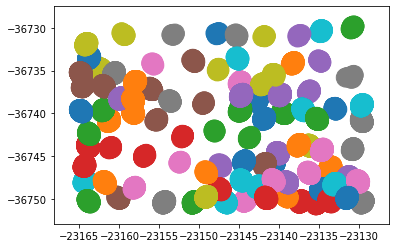

In [38]:
plot_2d(X_f,Y_f,Z_f,l_f)

In [39]:
clabel_3 = []
#clabel_3 = list(map(''.join, zip('cl_', label_3.astype(str))))
#clabel_3 = 'cl_' + str(label_3) 

for lbl in list(l_f):
    clabel_3.append('cl_' + str(lbl+1))
print(clabel_3[15])

cl_[1.]


In [40]:
dataset = pd.DataFrame({'Column1': X_f[:,0], 'Column2': Y_f[:,0],'Column3': Z_f[:,0], 'Column4': l_f[:,0]})
dataset.to_csv('./grid3_before_outlier_output.csv', header=None, index=None)

In [41]:
centr = extract_all_cluster_centers(X_f,Y_f,Z_f,R_f,l_f)

Cluster 0: center: (-23140.71,-36745.92), height: 19.36, width:0.49
Cluster 1: center: (-23161.26,-36740.85), height: 21.94, width:0.5
Cluster 2: center: (-23139.49,-36739.94), height: 21.77, width:0.5
Cluster 3: center: (-23135.24,-36750.46), height: 23.38, width:0.52
Cluster 4: center: (-23147.36,-36746.09), height: 17.92, width:0.5
Cluster 5: center: (-23160.06,-36749.88), height: 25.13, width:0.52
Cluster 6: center: (-23144.95,-36736.42), height: 18.01, width:0.51
Cluster 7: center: (-23129.67,-36740.87), height: 13.27, width:0.5
Cluster 8: center: (-23162.37,-36734.83), height: 15.55, width:0.49
Cluster 9: center: (-23134.8,-36730.37), height: 11.5, width:0.48
Cluster 10: center: (-23147.77,-36730.7), height: 3.81, width:0.46
Cluster 11: center: (-23133.62,-36746.28), height: 21.0, width:0.49
Cluster 12: center: (-23150.71,-36750.36), height: 17.94, width:0.51
Cluster 13: center: (-23163.92,-36743.82), height: 17.71, width:0.49
Cluster 14: center: (-23136.28,-36737.44), height: 22

In [42]:
X_f2,Y_f2,Z_f2,R_f2,l_f2 = filter_cluster_points_by_radius_height(X_f,Y_f,Z_f,R_f,l_f)

Number of points in cluster :0 dropped from 503 to 486
Number of points in cluster :1 dropped from 111 to 111
Number of points in cluster :2 dropped from 301 to 293
Number of points in cluster :3 dropped from 245 to 239
Number of points in cluster :4 dropped from 57 to 57
Number of points in cluster :5 dropped from 102 to 102
Number of points in cluster :6 dropped from 94 to 90
Number of points in cluster :7 dropped from 235 to 220
Number of points in cluster :8 dropped from 299 to 290
Number of points in cluster :9 dropped from 89 to 83
Number of points in cluster :10 dropped from 20 to 18
Number of points in cluster :11 dropped from 311 to 285
Number of points in cluster :12 dropped from 225 to 199
Number of points in cluster :13 dropped from 275 to 265
Number of points in cluster :14 dropped from 52 to 52
Number of points in cluster :15 dropped from 149 to 143
Number of points in cluster :16 dropped from 153 to 129
Number of points in cluster :17 dropped from 148 to 140
Number of po

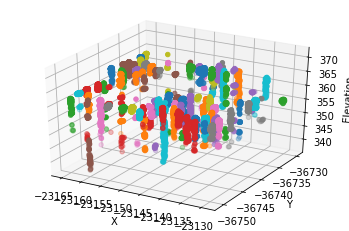

In [43]:
plot_3d(X_f2,Y_f2,Z_f2,l_f2)

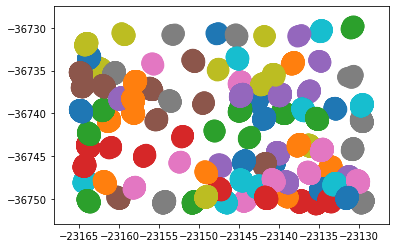

In [44]:
plot_2d(X_f2,Y_f2,Z_f2,l_f2)

In [45]:
centr2 = extract_all_cluster_centers(X_f2,Y_f2,Z_f2,R_f2,l_f2)

Cluster 0: center: (-23140.7,-36745.92), height: 8.8, width:0.49
Cluster 1: center: (-23161.26,-36740.85), height: 21.94, width:0.5
Cluster 2: center: (-23139.49,-36739.94), height: 3.21, width:0.5
Cluster 3: center: (-23135.24,-36750.46), height: 9.34, width:0.52
Cluster 4: center: (-23147.36,-36746.09), height: 17.92, width:0.5
Cluster 5: center: (-23160.06,-36749.88), height: 25.13, width:0.52
Cluster 6: center: (-23144.95,-36736.41), height: 13.64, width:0.51
Cluster 7: center: (-23129.66,-36740.88), height: 5.17, width:0.49
Cluster 8: center: (-23162.37,-36734.83), height: 5.16, width:0.49
Cluster 9: center: (-23134.81,-36730.36), height: 7.49, width:0.48
Cluster 10: center: (-23147.78,-36730.71), height: 0.92, width:0.37
Cluster 11: center: (-23133.62,-36746.28), height: 11.68, width:0.49
Cluster 12: center: (-23150.72,-36750.37), height: 1.6, width:0.51
Cluster 13: center: (-23163.93,-36743.82), height: 2.1, width:0.49
Cluster 14: center: (-23136.28,-36737.44), height: 22.59, wi

In [46]:
dataset = pd.DataFrame({'Column1': X_f2[:,0], 'Column2': Y_f2[:,0],'Column3': Z_f2[:,0], 'Column4': l_f2[:,0]})
dataset.to_csv('./grid3_outlier1_output.csv', header=None, index=None)

In [47]:
X_f3,Y_f3,Z_f3,R_f3,l_f3 = drop_cluster_with_lower_count(X_f2,Y_f2,Z_f2,R_f2,l_f2)

(91, 2)
Number of clusters dropped from 95 to 91


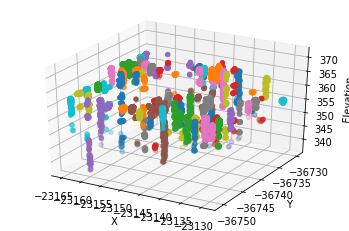

In [48]:
plot_3d(X_f3,Y_f3,Z_f3,l_f3)

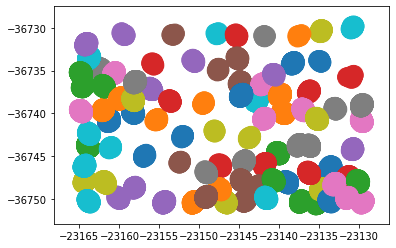

In [49]:
plot_2d(X_f3,Y_f3,Z_f3,l_f3)

In [50]:
centr3 = extract_all_cluster_centers(X_f3,Y_f3,Z_f3,R_f3,l_f3)

Cluster 1: center: (-23161.26,-36740.85), height: 21.94, width:0.5
Cluster 2: center: (-23139.49,-36739.94), height: 3.21, width:0.5
Cluster 3: center: (-23135.24,-36750.46), height: 9.34, width:0.52
Cluster 4: center: (-23147.36,-36746.09), height: 17.92, width:0.5
Cluster 5: center: (-23160.06,-36749.88), height: 25.13, width:0.52
Cluster 6: center: (-23144.95,-36736.41), height: 13.64, width:0.51
Cluster 7: center: (-23129.66,-36740.88), height: 5.17, width:0.49
Cluster 8: center: (-23162.37,-36734.83), height: 5.16, width:0.49
Cluster 9: center: (-23134.81,-36730.36), height: 7.49, width:0.48
Cluster 10: center: (-23147.78,-36730.71), height: 0.92, width:0.37
Cluster 11: center: (-23133.62,-36746.28), height: 11.68, width:0.49
Cluster 12: center: (-23150.72,-36750.37), height: 1.6, width:0.51
Cluster 13: center: (-23163.93,-36743.82), height: 2.1, width:0.49
Cluster 14: center: (-23136.28,-36737.44), height: 22.59, width:0.51
Cluster 15: center: (-23156.05,-36737.14), height: 2.36,

In [51]:
dataset = pd.DataFrame({'Column1': X_f3[:,0], 'Column2': Y_f3[:,0],'Column3': Z_f3[:,0], 'Column4': l_f3[:,0]})
dataset.to_csv('./grid3_outlier2_output.csv', header=None, index=None)

In [52]:
dataset = pd.DataFrame({'X': centr3[:,0], 'Y': centr3[:,1],'Z': centr3[:,2], 'label': centr3[:,4]})
dataset.to_csv('./grid3_outlier2_output_center.csv', header=None, index=None)